In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 200
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

#设置中文字体
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['MicrosoftYaHei'] 
mpl.rcParams['axes.unicode_minus'] = False 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# 特征选择，卡方校验，求p值
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# my utils
from ml_utils.utils import plot_learning_curve
from ml_utils.utils import plot_confusion_matrix
from ml_utils.utils import print_recall_precision_f1
from ml_utils.utils import plot_auc_curve

### 导入数据

- PassengerId => 乘客ID
- Pclass => 乘客等级(1/2/3等舱位)
- Name => 乘客姓名
- Sex => 性别
- Age => 年龄
- SibSp => 堂兄弟/妹个数
- Parch => 父母与小孩个数
- Ticket => 船票信息
- Fare => 票价
- Cabin => 客舱
- Embarked => 登船港口

In [2]:
data_origin = pd.read_csv('train.csv')
data_train = data_origin.copy()

In [3]:
data_train.shape

(891, 12)

- 一共十二个特征
- 891行数据，数据有点少

In [4]:
data_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 322.0 KB


- Age和Cabin有缺失值，Cabin比较多，Age还可以接受

In [5]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### 数据缺失率描述
- Object数据类型，将来可能做one-hot或label编码
- 非Object数据类型

In [7]:
def describe_missing(df,include=None,exclude=None):
    """
        用来描述datafame的Object类型与非object类型数据的基本情况与缺失率
        df: dataframe-like，要描述的数据
        include: list-like，选择的数据类型
        exclude: list-like，排除的数据类型
    """
    return df.select_dtypes(include=include,exclude=exclude).describe().T\
    .assign(missing_pct=df.apply(lambda x:(len(x)-x.count())/len(x)))    

In [8]:
describe_missing(data_train,include=['O'])

,count,unique,top,freq,missing_pct
Name,891,891,"Brown, Mr. Thomas William Solomon",1,0.000000
Sex,891,2,male,577,0.000000
Ticket,891,681,347082,7,0.000000
Cabin,204,147,G6,4,0.771044
Embarked,889,3,S,644,0.002245


- object字段中Cabin缺失率高达77%
- 在登船港口Embarked大多数都是S的

In [9]:
describe_missing(data_train,exclude=['O'])

,count,mean,std,min,25%,50%,75%,max,missing_pct
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000,0.000000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000,0.000000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000,0.000000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000,0.198653
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000,0.000000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000,0.000000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292,0.000000


- Survived平均值不足0.5，说明被救的人还是少数
- 平均年龄在29.7岁

### 各特征的分布图

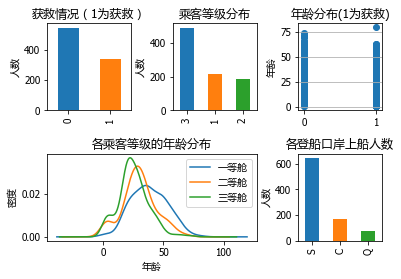

In [10]:
fig = plt.figure()
fig.set(alpha=0.2)

plt.subplot2grid((2,3),(0,0))
data_train.Survived.value_counts().plot(kind='bar')
plt.title('获救情况（1为获救）')
plt.ylabel('人数')

plt.subplot2grid((2,3),(0,1))
data_train.Pclass.value_counts().plot(kind='bar')
plt.title('乘客等级分布')
plt.ylabel('人数')

plt.subplot2grid((2,3),(0,2))
plt.scatter(data_train.Survived,data_train.Age)
plt.grid(b=True,axis='y') # 设置网格，方便对比查看
plt.title('年龄分布(1为获救)')
plt.ylabel('年龄')

plt.subplot2grid((2,3),(1,0),colspan=2)
data_train.Age[data_train.Pclass==1].plot(kind='kde')
data_train.Age[data_train.Pclass==2].plot(kind='kde')
data_train.Age[data_train.Pclass==3].plot(kind='kde')
plt.legend(('一等舱','二等舱','三等舱'),loc='best')
plt.title('各乘客等级的年龄分布')
plt.ylabel('密度')
plt.xlabel('年龄')

plt.subplot2grid((2,3),(1,2))
data_train.Embarked.value_counts().plot(kind='bar')
plt.title(u"各登船口岸上船人数")
plt.ylabel(u"人数")  

plt.subplots_adjust(wspace=0.5,hspace=0.5)
plt.show()

- 被救的人300多点，不到半数；
- 3等舱乘客灰常多；遇难和获救的人年龄似乎跨度都很广；
- 3个不同的舱年龄总体趋势似乎也一致，2/3等舱乘客20岁多点的人最多，1等舱40岁左右的最多(→_→似乎符合财富和年龄的分配哈，咳咳，别理我，我瞎扯的)；
- 登船港口人数按照S、C、Q递减，而且S远多于另外俩港口。

这个时候我们可能会有一些想法了：


- 不同舱位/乘客等级可能和财富/地位有关系，最后获救概率可能会不一样
- 年龄对获救概率也一定是有影响的，毕竟前面说了，副船长还说『小孩和女士先走』呢
- 和登船港口是不是有关系呢？也许登船港口不同，人的出身地位不同？

### 不同舱等级对是否获救的影响

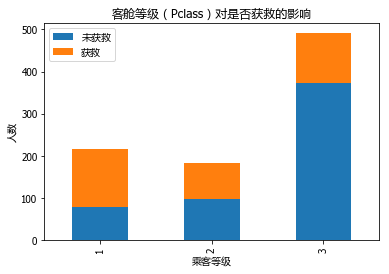

In [11]:
survived_0 = data_train[data_train.Survived==0].Pclass.value_counts()
survived_1 = data_train[data_train.Survived==1].Pclass.value_counts()
df = pd.DataFrame({'未获救':survived_0,'获救':survived_1})
# stacked = True 表示叠加
df.plot(kind='bar',stacked=True)
plt.ylabel('人数')
plt.xlabel('乘客等级')
plt.title('客舱等级（Pclass）对是否获救的影响')
plt.show()

- 乘客等级为1的获救比例最高，等级2次之，等级3比例最小，随着客舱等级的不同获救的比例不同
- 乘客等级对是否获救是有影响的

### 用卡方校验

In [12]:
# 输入不同的k可以从多个特征中选择最相关的
chi2_model = SelectKBest(chi2,k=1)
_ = chi2_model.fit_transform(data_train.loc[:,['Pclass']],data_train.Survived)
# p值小于0.05有显著统计特征，p值越小说明特征与target之前越相关
print('p值：',chi2_model.pvalues_)

p值： [2.75378563e-08]


### 性别对是否获救的影响

Text(0.5, 1.0, '性别对获救的影响')

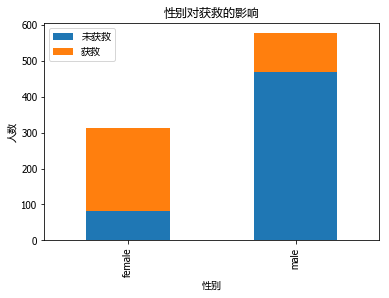

In [13]:
survived_sex_0 = data_train[data_train.Survived==0].Sex.value_counts()
survived_sex_1 = data_train[data_train.Survived==1].Sex.value_counts()
df_sex = pd.DataFrame({'未获救':survived_sex_0,'获救':survived_sex_1})
df_sex.plot(kind='bar',stacked=True)
plt.ylabel('人数')
plt.xlabel('性别')
plt.title('性别对获救的影响')

- 可以看出来女性的获救比例比男性高不少
- 性别对是否获救是有比较强的影响，是一个重要特征

### 在不同的乘客等级中，性别对是否获救的影响

In [14]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


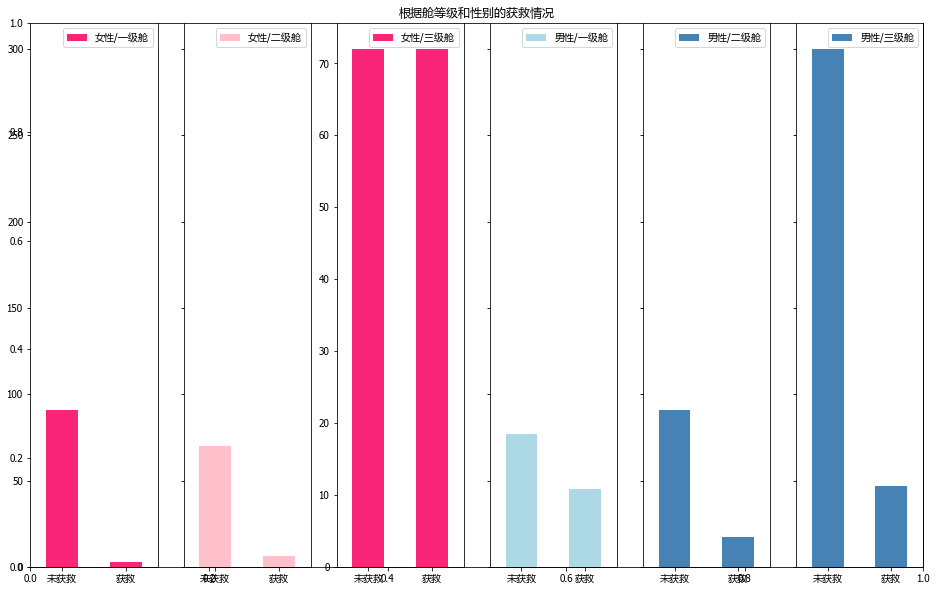

In [15]:
#然后我们再来看看各种舱级别情况下各性别的获救情况
fig=plt.figure(figsize=(16,10))
fig.set(alpha=0.65) # 设置图像透明度，无所谓
plt.title(u"根据舱等级和性别的获救情况")

ax1=fig.add_subplot(161)
data_train.Survived[np.logical_and(data_train.Sex=='female',data_train.Pclass==1)].value_counts().plot(kind='bar',label="female highclass", color='#FA2479')
ax1.set_xticklabels([u"未获救", u"获救"], rotation=0)
ax1.legend([u"女性/一级舱"], loc='best')

ax2=fig.add_subplot(162, sharey=ax1)
data_train.Survived[data_train.Sex == 'female'][data_train.Pclass == 2].value_counts().plot(kind='bar', label='female, low class', color='pink')
ax2.set_xticklabels([u"未获救", u"获救"], rotation=0)
plt.legend([u"女性/二级舱"], loc='best')

ax3=fig.add_subplot(163)
data_train.Survived[np.logical_and(data_train.Sex=='female',data_train.Pclass==3)].value_counts().plot(kind='bar',label="female highclass", color='#FA2479')
ax3.set_xticklabels([u"未获救", u"获救"], rotation=0)
ax3.legend([u"女性/三级舱"], loc='best')

ax4=fig.add_subplot(164, sharey=ax1)
data_train.Survived[data_train.Sex == 'male'][data_train.Pclass == 1].value_counts().plot(kind='bar', label='male, high class',color='lightblue')
ax4.set_xticklabels([u"未获救", u"获救"], rotation=0)
ax4.legend([u"男性/一级舱"], loc='best')

ax5=fig.add_subplot(165, sharey=ax1)
data_train.Survived[data_train.Sex == 'male'][data_train.Pclass == 2].value_counts().plot(kind='bar', label='male low class', color='steelblue')
ax5.set_xticklabels([u"未获救", u"获救"], rotation=0)
ax5.legend([u"男性/二级舱"], loc='best')

ax6=fig.add_subplot(166, sharey=ax1)
data_train.Survived[data_train.Sex == 'male'][data_train.Pclass == 3].value_counts().plot(kind='bar', label='male low class', color='steelblue')
ax6.set_xticklabels([u"未获救", u"获救"], rotation=0)
ax6.legend([u"男性/三级舱"], loc='best')

plt.show()

- 这个图表示不同船舱中，不同性别的获救情况。
- 在高级船舱中，女性获救的比较也不高。对总体获救女性贡献最大的是3级船舱的女性。也就是说，
- 在3级船舱中的女性更容易被获救

### 不同登船港口对是否获救的影响

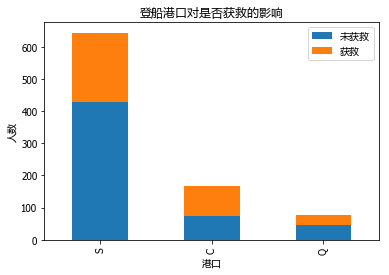

In [16]:
survived_embarked_0 = data_train[data_train.Survived==0].Embarked.value_counts()
survived_embarked_1 = data_train[data_train.Survived==1].Embarked.value_counts()
df_embarked = pd.DataFrame({'未获救':survived_embarked_0,'获救':survived_embarked_1})
df_embarked.plot(kind='bar',stacked=True)
plt.ylabel('人数')
plt.xlabel('港口')
plt.title('登船港口对是否获救的影响')
plt.show()

- 感觉不同港口对是否获救没有啥影响

### 堂兄弟/妹人数

In [17]:
# passengerId是唯一的，所以根据两个字段聚合后是看不同SibSp人数下，分类是否获救的人数
g_sbisp = data_train.groupby(['SibSp','Survived'])
df_sbisp = pd.DataFrame(g_sbisp.count()['PassengerId'])
df_sbisp

PassengerId
SibSp Survived             
0     0                 398
      1                 210
1     0                  97
      1                 112
2     0                  15
      1                  13
3     0                  12
      1                   4
4     0                  15
      1                   3
5     0                   5
8     0                   7

### 父母与子女的个数

In [18]:
g_parch = data_train.groupby(['Parch','Survived'])
df_parch = DataFrame(g_parch.count()['PassengerId'])
df_parch

PassengerId
Parch Survived             
0     0                 445
      1                 233
1     0                  53
      1                  65
2     0                  40
      1                  40
3     0                   2
      1                   3
4     0                   4
5     0                   4
      1                   1
6     0                   1

- 从堂兄弟个数&父母子女个数上没有看出什么规律，先作为备选特征

### 客舱Carbin处理
- 缺失率比较高
- 作为类别太分散，不集中，每个因子化后的特征拿不一，如果把每一个作为一种类别时，每个因子化的特征拿到权重都不大。
- 如果是连续型的，则把有数据离散化，把没有数据的作为一类。
- 处理方式：把有数据的作为一类，把没有数据的作为另一类。

In [ ]:
# data_train.Cabin.value_counts()

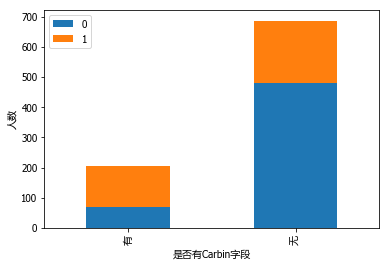

In [ ]:
survived_cabin = data_train.Survived[data_train.Cabin.notnull()].value_counts()
notsurvived_cabin = data_train.Survived[data_train.Cabin.isnull()].value_counts()
df = pd.DataFrame({'有':survived_cabin,'无':notsurvived_cabin}).T
df.plot(kind='bar',stacked=True)
plt.xlabel('是否有Carbin字段')
plt.ylabel('人数')
plt.show()

有Carbin字段的获救的比例大一些

### 使用随机森林来填充缺失的年龄

In [ ]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
def set_missing_age(df):
    # 把已经有的数值类型的特征进行随机森林回归
    cols = ['Age','Fare', 'Parch', 'SibSp', 'Pclass']
    age_df = df[cols]
    
    # 把数据分成已知年龄和未知年龄的
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()
    konwn_age = age_df[age_df.Age.notnull()].as_matrix()
    
    y = konwn_age[:,0]
    X = konwn_age[:,1:]
    
    # 使用随机森林进行回归
    rf_reg = RandomForestRegressor(random_state=0,n_estimators=2000,n_jobs=-1)
    rf_reg.fit(X,y)
     
    predict_ages = rf_reg.predict(unknown_age[:, 1::])
    
    # 用得到的预测结果填补原缺失数据
    df.loc[df.Age.isnull(),'Age'] = predict_ages
    
    return df, rf_reg


# 先设置非空的再设置空的
def set_Cabin_type(df):
    df.loc[df.Cabin.notnull(),'Cabin'] = 'Yes'
    df.loc[df.Cabin.isnull(),'Cabin'] = 'No'
    return df

In [ ]:
data_train, rf_reg = set_missing_age(data_train)
data_train = set_Cabin_type(data_train)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


###  对Pclass,sex,Cabin,Embarked进行onehot处理
- 查看数据状，并做one-hot处理

In [ ]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,No,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,Yes,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,No,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,Yes,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,No,S


In [ ]:
describe_missing(data_train,include=['O'])

,count,unique,top,freq,missing_pct
Name,891,891,"Brown, Mr. Thomas William Solomon",1,0.000000
Sex,891,2,male,577,0.000000
Ticket,891,681,347082,7,0.000000
Cabin,891,2,No,687,0.000000
Embarked,889,3,S,644,0.002245


In [ ]:
describe_missing(data_train,exclude=['O'])

,count,mean,std,min,25%,50%,75%,max,missing_pct
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000,0.0
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000,0.0
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000,0.0
Age,891.0,29.647248,13.629879,0.42,21.0000,29.0000,36.0,80.0000,0.0
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000,0.0
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000,0.0
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292,0.0


In [ ]:
data = pd.get_dummies(data_train,prefix=['Pclass','Sex','Cabin','Emabarked'],columns=['Pclass','Sex','Cabin','Embarked'])

### 删除Name，Ticked列

In [ ]:
data.drop(['Name','Ticket'],inplace=True,axis=1)

In [ ]:
data.drop(['PassengerId'],inplace=True,axis=1)

In [ ]:
data.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Cabin_No,Cabin_Yes,Emabarked_C,Emabarked_Q,Emabarked_S
0,0,22.0,1,0,7.2500,0,0,1,0,1,1,0,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,0,1,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,1,0,0,1,0,0,1
4,0,35.0,0,0,8.0500,0,0,1,0,1,1,0,0,0,1


### Age和 Fare的数据太大，对LR不友好，如果不归一化LR在梯度下降时不容易收敛
对这两个特征进行归一化

In [ ]:
scaler = preprocessing.StandardScaler(copy=True)
age_fare_scaled = scaler.fit_transform(data[['Age','Fare']])
data['Age'] = age_fare_scaled[:,0]
data['Fare'] = age_fare_scaled[:,1]

### 把开发集分为train set 和test set，做一个baseline

In [ ]:
X = data.iloc[:,1:]
y = data.iloc[:,0]
print('X.shape:',X.shape,',y.shape:',y.shape)
X_train,X_test,y_train,y_test = train_test_split(X,y)
print('X_tran.shape:',X_train.shape,',y_train.shape:',y_train.shape,',X_test:',X_test.shape,',y_test:',y_test.shape)

X.shape: (891, 14) ,y.shape: (891,)
X_tran.shape: (668, 14) ,y_train.shape: (668,) ,X_test: (223, 14) ,y_test: (223,)


In [ ]:
lr_clf = LogisticRegression(C=1.0,penalty='l2')
lr_clf.fit(X=X_train,y=y_train)
y_predict = lr_clf.predict(X=X_test)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
lr_clf.score(X_test,y_test)

0.7892376681614349

### 用learning_curve看曲线

In [ ]:
from sklearn.model_selection import learning_curve

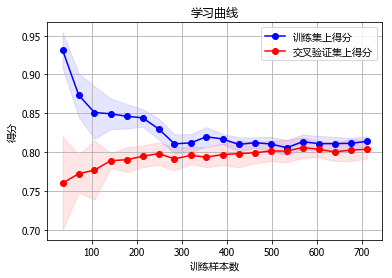

(0.8060300029301395, 0.028715079670677657)

In [ ]:
# 这里难道是使用X_train y_train吗,不对的，是使用all_data
plot_learning_curve(lr_clf,cv=5,title='学习曲线',X=X,y=y)

### 二分类问题的评估
- 混淆矩阵
- recall-precision
- auc

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

Confusion matrix, without normalization
[[112  17]
 [ 30  64]]


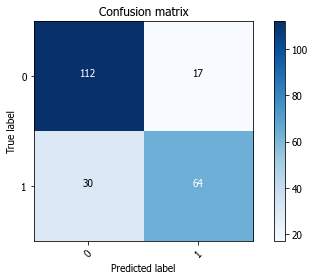

In [ ]:
plot_confusion_matrix(y_test,y_predict,classes=[0,1])

In [ ]:
print_recall_precision_f1(y_test,y_predict)

precision score: 0.7901
recall score: 0.6809
f1 score: 0.7314


In [ ]:
y_score = lr_clf.predict_proba(X_test)

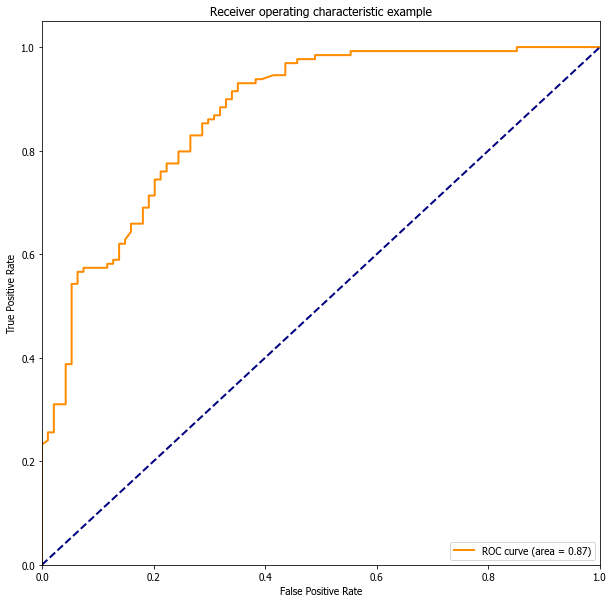

In [ ]:
plot_auc_curve(y_test,y_score)

In [ ]:
lr_clf.coef_.T.flatten()
coef_df = pd.DataFrame({"columns":list(X_train.columns), "coef":lr_clf.coef_.T.flatten()})
coef_df.sort_values(by=['coef'],ascending=False)

,columns,coef
7,Sex_female,1.498686
4,Pclass_1,0.869506
10,Cabin_Yes,0.413907
5,Pclass_2,0.259718
12,Emabarked_Q,0.242737
11,Emabarked_C,0.181371
3,Fare,0.048918
2,Parch,-0.121313
9,Cabin_No,-0.167926
1,SibSp,-0.318997


- Sex属性，如果是female会极大提高最后获救的概率，而male会很大程度拉低这个概率。
- Pclass属性，1等舱乘客最后获救的概率会上升，而乘客等级为3会极大地拉低这个概率。
- 有Cabin值会很大程度拉升最后获救概率(这里似乎能看到了一点端倪，事实上从最上面的有无Cabin记录的 - Survived分布图上看出，即使有Cabin记录的乘客也有一部分遇难了，估计这个属性上我们挖掘还不够)
- Age是一个负相关，意味着在我们的模型里，年龄越小，越有获救的优先权(还得回原数据看看这个是否合理）
- 有一个登船港口S会很大程度拉低获救的概率，另外俩港口压根就没啥作用(这个实际上非常奇怪，因为我们从之前的统计图上并没有看到S港口的获救率非常低，所以也许可以考虑把登船港口这个feature去掉试试)。
- 船票Fare有小幅度的正相关(并不意味着这个feature作用不大，有可能是我们细化的程度还不够，举个例子，说不定我们得对它离散化，再分至各个乘客等级上？)
* Age属性不使用现在的拟合方式，而是根据名称中的『Mr』『Mrs』『Miss』等的平均值进行填充。
* Age不做成一个连续值属性，而是使用一个步长进行离散化，变成离散的类目feature。
* Cabin再细化一些，对于有记录的Cabin属性，我们将其分为前面的字母部分(我猜是位置和船层之类的信息) 和 后面的数字部分(应该是房间号，有意思的事情是，如果你仔细看看原始数据，你会发现，这个值大的情况下，似乎获救的可能性高一些)。
* Pclass和Sex俩太重要了，我们试着用它们去组出一个组合属性来试试，这也是另外一种程度的细化。
* 单加一个Child字段，Age<=12的，设为1，其余为0(你去看看数据，确实小盆友优先程度很高啊)
* 如果名字里面有『Mrs』，而Parch>1的，我们猜测她可能是一个母亲，应该获救的概率也会提高，因此可以多加一个Mother字段，此种情况下设为1，其余情况下设为0
* 登船港口可以考虑先去掉试试(Q和C本来就没权重，S有点诡异)
* 把堂兄弟/兄妹 和 Parch 还有自己 个数加在一起组一个Family_size字段(考虑到大家族可能对最后的结果有影响)
* Name是一个我们一直没有触碰的属性，我们可以做一些简单的处理，比如说男性中带某些字眼的(‘Capt’, ‘Don’, ‘Major’, ‘Sir’)可以统一到一个Title，女性也一样。

### 根据LR的coef也就是权重再深挖特征工程，用tree-based

In [ ]:
seed = 2019

In [ ]:
df_data = data_origin.copy()
df_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# 匹配字符串，如果title在名字中，则返回title，否则填充空值
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if substring in big_string:
            return substring
    print(big_string)
    return np.nan

In [ ]:
def handle_data(data_df):
    #处理一下名字，生成Title字段
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                'Don', 'Jonkheer']
    data_df['Title'] = data_df.Name.apply(lambda x: substrings_in_string(x,title_list))
    #处理特殊的称呼，全处理成mr, mrs, miss, master
    def replace_titles(x):
        title=x['Title']
        if title in ['Mr','Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
            return 'Mr'
        elif title in ['Master']:
            return 'Master'
        elif title in ['Countess', 'Mme','Mrs']:
            return 'Mrs'
        elif title in ['Mlle', 'Ms','Miss']:
            return 'Miss'
        elif title =='Dr':
            if x['Sex']=='Male':
                return 'Mr'
            else: 
                return 'Mrs'
        elif title =='':
            if x['Sex']=='Male':
                return 'Master'
            else:
                return 'Miss'
        else:
            return title

    data_df['Title'] = data_df.apply(replace_titles,axis=1)
    #看看家族是否够大，咳咳
    data_df['Family_Size']=data_df['SibSp'] + data_df['Parch']
    # 这个乘，不理解
    data_df['Family']=data_df['SibSp']*data_df['Parch']

    # 把Fare是空值的补充这一类的平均值（去除na后再平均）
    data_df.loc[np.logical_and(data_df.Fare.isnull(),data_df.Pclass==1),'Fare'] = np.median(data_df[data_df['Pclass']==1]['Fare'].dropna())
    data_df.loc[np.logical_and(data_df.Fare.isnull(),data_df.Pclass==2),'Fare'] = np.median(data_df[data_df['Pclass']==2]['Fare'].dropna())
    data_df.loc[np.logical_and(data_df.Fare.isnull(),data_df.Pclass==3),'Fare'] = np.median(data_df[data_df['Pclass']==3]['Fare'].dropna())

    # 把性别map为0，1，并且为int类型
    data_df['Gender'] = data_df['Sex'].map({'female': 0, 'male': 1} ).astype(int)

    #处理年龄
    data_df['AgeFill']=data_df['Age']
    mean_ages = np.zeros(4)
    mean_ages[0]=np.average(data_df[data_df['Title'] == 'Miss']['Age'].dropna())
    mean_ages[1]=np.average(data_df[data_df['Title'] == 'Mrs']['Age'].dropna())
    mean_ages[2]=np.average(data_df[data_df['Title'] == 'Mr']['Age'].dropna())
    mean_ages[3]=np.average(data_df[data_df['Title'] == 'Master']['Age'].dropna())
    data_df.loc[ (data_df.Age.isnull()) & (data_df.Title == 'Miss') ,'AgeFill'] = mean_ages[0]
    data_df.loc[ (data_df.Age.isnull()) & (data_df.Title == 'Mrs') ,'AgeFill'] = mean_ages[1]
    data_df.loc[ (data_df.Age.isnull()) & (data_df.Title == 'Mr') ,'AgeFill'] = mean_ages[2]
    data_df.loc[ (data_df.Age.isnull()) & (data_df.Title == 'Master') ,'AgeFill'] = mean_ages[3]

    #把年龄分类
    data_df['AgeCat']=data_df['AgeFill']
    data_df.loc[ (data_df.AgeFill<=10) ,'AgeCat'] = 'child'
    data_df.loc[ (data_df.AgeFill>60),'AgeCat'] = 'aged'
    data_df.loc[ (data_df.AgeFill>10) & (data_df.AgeFill <=30) ,'AgeCat'] = 'adult'
    data_df.loc[ (data_df.AgeFill>30) & (data_df.AgeFill <=60) ,'AgeCat'] = 'senior'

    #空值填充众数
    data_df.Embarked = data_df.Embarked.fillna('S')

    # 把没有数据的给了0.5，而有数据的给了1.5
    data_df.loc[data_df.Cabin.isnull()==True,'Cabin'] = 0.5
    data_df.loc[data_df.Cabin.isnull()==False,'Cabin'] = 1.5

    data_df['Fare_Per_Person']=data_df['Fare']/(data_df['Family_Size']+1)
    #Age times class

    data_df['AgeClass']=data_df['AgeFill']*data_df['Pclass']
    data_df['ClassFare']=data_df['Pclass']*data_df['Fare_Per_Person']


    data_df['HighLow']=data_df['Pclass']
    data_df.loc[ (data_df.Fare_Per_Person<8) ,'HighLow'] = 'Low'
    data_df.loc[ (data_df.Fare_Per_Person>=8) ,'HighLow'] = 'High'

    # 如果用tree-based的模型则可以不用one-hot
    # 也不用归一化，也不用排序异常值
    label_encoder = LabelEncoder()

    label_list = ['Ticket','Title','AgeCat','HighLow','Embarked']
    for col in label_list:
        # 为什么是float类型的？？？
        data_df[col] = label_encoder.fit_transform(data_df[col]).astype(np.float)

    drop_cols = ['PassengerId','Name','Sex','Age','Cabin']
    data_df.drop(columns=drop_cols,inplace=True)
    
    return data_df

In [ ]:
df_data = handle_data(df_data)

### 数据分割

In [ ]:
y = df_data.pop('Survived')
X = df_data
X_train,X_test,y_train,y_test = train_test_split(X,y)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(668, 16) (223, 16) (668,) (223,)


### 随机森林调参
- e_estimators: 子分类器的个数，默认是10，建议调参范围：10~200
- max_depth: 树的最大深度，默认是None，RF在创建决策树时，不限制树的生成，使得每个叶节点只有一个类别，或者是达到min_samples_split。建议调参范围：10~100
- max_features:划分时考虑的最大特征数，默认是None,即考虑所有特征。'auto'是sqtr(n_features)
- min_smaples_split:内部节点划分所需要的最小样本数。默认是2。如果小于2则不再进行划分，如果等于2还是要划分的。可以控制数的生长。
- min_smaples_leaf:叶子节点最少样本数，默认是1.如果小于叶子节点最少样本数，则会与兄弟节点一起剪枝。这个参数与mi_samples_split并不冲突。假设一个节点有4个样本，设置min_samples_leaf=2，4个样本分为了3和1两个节点，这种情况下则会被剪枝。

In [ ]:
#初始化分类器
rf_clf=RandomForestClassifier(n_estimators=100, max_depth=5,criterion='gini',
                              max_features='auto', 
                              min_samples_split=2,
                              min_samples_leaf=1, 
                              max_leaf_nodes=None,
                              bootstrap=False, oob_score=False, 
                              n_jobs=-1, random_state=seed)

In [ ]:
rf_clf.fit(X_train,y_train)
y_predict = rf_clf.predict(X_test)

In [ ]:
print_recall_precision_f1(y_true=y_test,y_pred=y_predict)

precision score: 0.8310
recall score: 0.7662
f1 score: 0.7973


In [ ]:
print('AUC:',roc_auc_score(y_test,rf_clf.predict_proba(X_test)[:,1]))

AUC: 0.8852072584949299


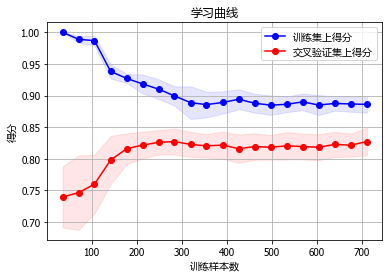

(0.8522309216338106, 0.09382286368587434)

In [ ]:
plot_learning_curve(estimator=rf_clf,cv=5,X=X,y=y)

- 从学习曲线上看过拟合了
- 需要对RandomForest进行调参

### 使用GridSearchCV，非常耗时的，参数个数成指数增加

In [ ]:
param1 = {'n_estimators':range(10,101,10),'max_depth':range(10,101,10),
          'min_samples_split':range(10,101,10),'min_samples_leaf':range(10,101,10)}
gs = GridSearchCV(estimator=RandomForestClassifier(oob_score=False,max_features='auto',n_jobs=-1,random_state=seed),
            scoring='f1',
            param_grid=param1,
            cv=5,
            n_jobs=-1,
            verbose=1)
gs.fit(X,y)
gs.best_params_

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 6002 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 7152 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 8402 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 9752 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 11202 tasks      

In [ ]:
best_rf_clf = RandomForestClassifier(n_estimators=80,max_depth=30,
                                     max_features='auto',
                                     random_state=seed,
                                     min_samples_leaf=2,
                                     min_samples_split=8,
                                     oob_score=False,
                                     n_jobs=-1)
best_rf_clf.fit(X_train,y_train)
y_predict = best_rf_clf.predict(X_test)
print_recall_precision_f1(y_test,y_predict)

plot_learning_curve(estimator=best_rf_clf,X=X,y=y,cv=5)

# 使用LightGBM算法

In [ ]:
y.value_counts()

### baseline

In [ ]:
# min_split_gain: 分裂的最小增益，可以防止过拟合
# subsample_for_bin: 采样组成直方图bins的样本个数
# （1）number of data that sampled to construct histogram bins
# （2）setting this to larger value will give better training result, but will increase data loading time
# （3）set this to larger value if data is very sparse
# metric: binary_error
# scale_pos_weight： 默认就是1.0
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': -1, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt',max_depth=-1,objective='binary',n_jobs=-1,num_leaves=64,learning_rate=0.05,max_bin=512,subsample_for_bin=200,subsample=1,subsample_freq=1,colsample_bytree=0.8,reg_alpha=5,reg_lamba=10,min_split_gain=0.5,min_child_weight=1,min_child_samples=5,scale_pos_weight=1,num_class=1,metric='binary_error')

In [ ]:
lgb_clf.fit(X_train,y_train)

In [ ]:
y_pred = lgb_clf.predict(X_test)

In [ ]:
# 召回率61%
recall_score(y_true=y_test,y_pred=y_pred)

In [ ]:
# 精准率
precision_score(y_test,y_pred)

In [ ]:
gridParams = {
    'learning_rate': [0.005],
    'n_estimators': [40],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
}

In [ ]:
# 模型是使用的baseline
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

In [ ]:
# To view the default model params:
mdl.get_params().keys()

In [ ]:
# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=2,
                    cv=4,
                    n_jobs=-1)

In [ ]:
# # Run the grid
# grid.fit(X_train, y_train)

# # Print the best parameters found
# print(grid.best_params_)
# print(grid.best_score_)

# # Using parameters already set above, replace in the best from the grid search
# params['colsample_bytree'] = grid.best_params_['colsample_bytree']
# params['learning_rate'] = grid.best_params_['learning_rate']
# # params['max_bin'] = grid.best_params_['max_bin']
# params['num_leaves'] = grid.best_params_['num_leaves']
# params['reg_alpha'] = grid.best_params_['reg_alpha']
# params['reg_lambda'] = grid.best_params_['reg_lambda']
# params['subsample'] = grid.best_params_['subsample']
# # params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

# print('Fitting with params: ')
# print(params)